<a href="https://colab.research.google.com/github/SujanVulasala/Detection-of-Crop-Insurance-Fraud-using-Aerial-Image-Analysis/blob/main/Experiment_PMFBY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task
Develop an anomaly-based fraud risk detection system using the 'PMFBY Coverage.csv' dataset. The system should utilize Isolation Forest, Local Outlier Factor (LOF), and One-Class SVM models to identify high-risk claims. Include comprehensive data preprocessing, model training, anomaly score generation, evaluation metrics such as percentage of high-risk claims, anomaly score distribution visualizations, identification of top-K suspicious claims, and an assessment of model agreement. Finally, summarize the findings, clearly distinguishing between fraud risk and confirmed fraud, and present the results in a clean, reproducible Jupyter Notebook suitable for a capstone review and research paper.

## Load Dataset

### Subtask:
Load the 'PMFBY Coverage.csv' dataset into a pandas DataFrame and display its head, info, and basic descriptive statistics to understand the data structure and initial characteristics.


**Reasoning**:
To begin, I will import the pandas library and load the 'PMFBY Coverage.csv' dataset into a DataFrame. Then, I'll display the first few rows, a concise summary, and descriptive statistics to get an initial understanding of the data's structure and characteristics.



In [ ]:
import pandas as pd
import os

file_path_base = '/content/PMFBY Coverage.csv'
sample_data_dir = 'sample_data/'

try:
    # First, try to list contents of 'sample_data' to debug
    print(f"\nContents of '{sample_data_dir}':")
    print(os.listdir(sample_data_dir))

    # Attempt to load the file from the common 'sample_data' directory
    file_path = os.path.join(sample_data_dir, file_path_base)
    df = pd.read_csv(file_path)

    # Display the first 5 rows of the DataFrame
    print("\nDataFrame Head:")
    print(df.head())

    # Print a concise summary of the DataFrame
    print("\nDataFrame Info:")
    df.info()

    # Generate descriptive statistics for numerical columns
    print("\nDescriptive Statistics:")
    print(df.describe())

except FileNotFoundError:
    print(f"\nError: The file '{file_path_base}' was not found in '{sample_data_dir}' or the root directory.")
    print("Please ensure the file is uploaded to the correct location or provide the correct path.")
    print("\nFiles in current directory:")
    print(os.listdir('.'))
    print(f"\nIf the file exists within '{sample_data_dir}' but under a different name, please verify.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")


Contents of 'sample_data/':
['README.md', 'anscombe.json', 'california_housing_test.csv', 'mnist_test.csv', 'mnist_train_small.csv', 'california_housing_train.csv']

DataFrame Head:
   sssyName.year sssyName.seasonName               sssyName.schemeName  \
0           2021              Kharif  Pradhan Mantri Fasal Bima Yojana   
1           2021              Kharif  Pradhan Mantri Fasal Bima Yojana   
2           2022              Kharif  Pradhan Mantri Fasal Bima Yojana   
3           2018              Kharif  Pradhan Mantri Fasal Bima Yojana   
4           2018              Kharif  Pradhan Mantri Fasal Bima Yojana   

  sssyName.stateName level3Name             cropName  sumInsured  premiumRate  \
0                Goa  North Goa               Pulses     37500.0       2.0000   
1                Goa  North Goa  Groundnut (Pea Nut)     47500.0       2.0000   
2            HARYANA  Fatehabad       Cotton (Kapas)     89903.0      12.0000   
3            Haryana    Sonipat        Maize (Ma

## Initial Data Analysis

### Subtask:
Perform an initial analysis of the dataset, including checking for unique values, data types, and identifying potential categorical and numerical features suitable for anomaly detection. This step will help in understanding the feature space.


**Reasoning**:
To begin the initial data analysis, I need to understand the cardinality of each feature. Displaying the number of unique values for every column will help in distinguishing between categorical, numerical, and identifier columns, which is crucial for subsequent feature engineering and model selection. After counting unique values, I will classify the columns based on their data type and unique value counts.



In [ ]:
print("\nUnique values per column:")
unique_counts = df.nunique()
print(unique_counts)

# Identify numerical and categorical columns based on dtype and unique value counts
numerical_cols = []
categorical_cols = []

# Define a threshold for considering a column as categorical based on unique values
# This threshold can be adjusted based on domain knowledge or further inspection.
CATEGORICAL_UNIQUE_THRESHOLD = 50

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        # Numerical columns
        numerical_cols.append(col)
    elif df[col].dtype == 'object':
        # Object type columns can be categorical or free text/identifiers
        if unique_counts[col] < CATEGORICAL_UNIQUE_THRESHOLD:
            categorical_cols.append(col)
        # else: columns with many unique object values are not immediately useful as categories
            # and might require further text processing or exclusion.

print(f"\nIdentified Numerical Columns ({len(numerical_cols)}): {numerical_cols}")
print(f"Identified Categorical Columns ({len(categorical_cols)}): {categorical_cols}")


Unique values per column:
sssyName.year                              5
sssyName.seasonName                        2
sssyName.schemeName                        2
sssyName.stateName                        38
level3Name                               505
                                        ... 
websiteLink                               16
sssyName.schemeNameShort                   2
insuranceCompany.insuranceCompanyID       17
insuranceCompany.insuranceCompanyCode     17
insuranceCompany.insuranceCompanyName     17
Length: 62, dtype: int64

Identified Numerical Columns (30): ['sssyName.year', 'sumInsured', 'premiumRate', 'stateShare', 'goiShare', 'sssyID', 'seasonCode', 'schemeCode', 'stateCode', 'year', 'isOpen', 'cnStarted', 'cnIsCopied', 'policy', 'notification', 'ayTy', 'yieldEndDate', 'currentTime', 'default', 'level3Code', 'cropCode', 'type', 'unit', 'cropTypeCode', 'indemnityLevel', 'farmerShare', 'farmerShareValue', 'goiShareValue', 'stateShareValue', 'insuranceCompany.insuran

**Reasoning**:
To visualize the distributions of numerical features and understand the frequency of categories in categorical features, I will generate histograms for key numerical columns and display value counts for categorical columns. This helps in identifying potential outliers and understanding data patterns relevant for anomaly detection.




Visualizing distributions of selected numerical columns:


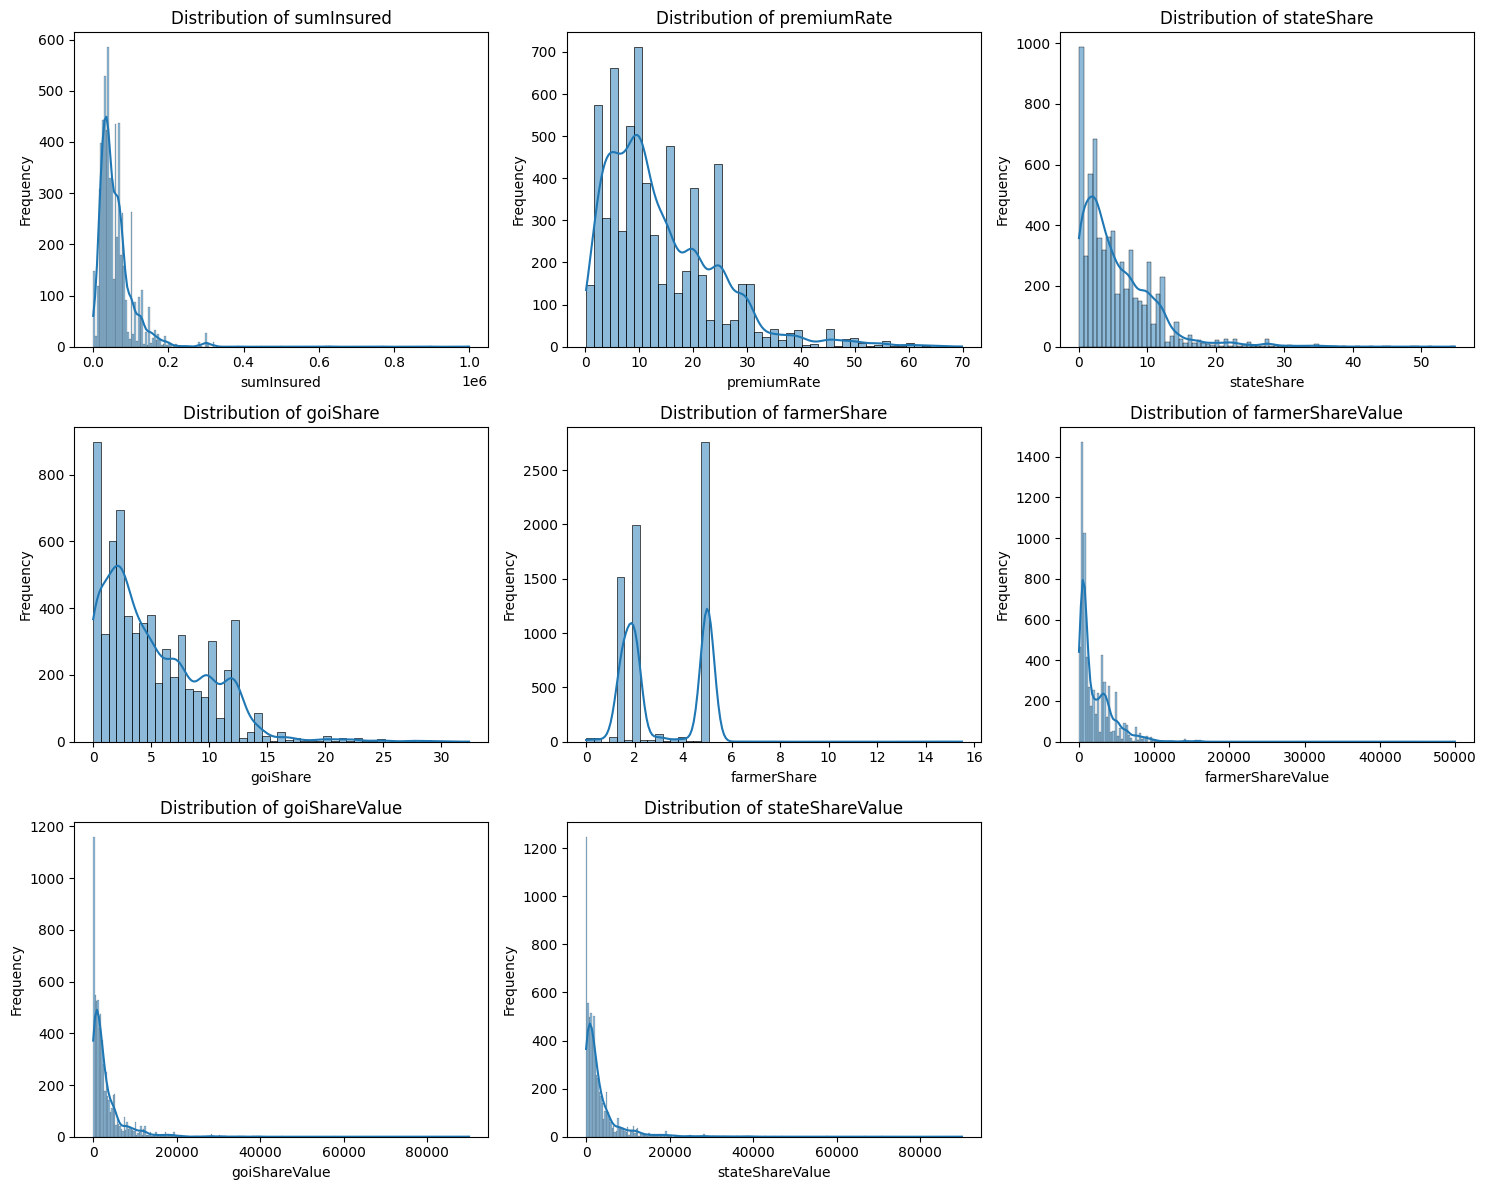


Value counts for categorical columns:

--- Column: sssyName.seasonName ---
sssyName.seasonName
Kharif    3367
Rabi      3213
Name: count, dtype: int64

--- Column: sssyName.schemeName ---
sssyName.schemeName
Pradhan Mantri Fasal Bima Yojana       4112
Weather Based Crop Insurance Scheme    2468
Name: count, dtype: int64

--- Column: sssyName.stateName ---
sssyName.stateName
Madhya Pradesh    1317
Chhattisgarh      1130
Kerala             357
Uttar Pradesh      349
Haryana            332
Rajasthan          324
CHHATTISGARH       263
Gujarat            262
Maharashtra        242
MADHYA PRADESH     239
Name: count, dtype: int64
... and 28 more unique values.

--- Column: seasonID ---
seasonID
CAF3184F-7713-482A-9C39-EBCFF9490D58    3367
35BF6040-B366-47B6-BC84-BF55AB8BE18B    3213
Name: count, dtype: int64

--- Column: schemeID ---
schemeID
6F0AF1C1-19B2-40F5-AEAB-B8E0E374598F    4112
CF11E013-1ADE-491B-ABAE-C6C098211CA5    2468
Name: count, dtype: int64

--- Column: stateID ---
stateID


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize distributions of key numerical columns
print("\nVisualizing distributions of selected numerical columns:")
selected_numerical_for_plotting = [
    'sumInsured', 'premiumRate', 'stateShare', 'goiShare',
    'farmerShare', 'farmerShareValue', 'goiShareValue', 'stateShareValue'
]

# Filter to ensure only columns present in the DataFrame are selected
selected_numerical_for_plotting = [col for col in selected_numerical_for_plotting if col in df.columns]

if selected_numerical_for_plotting:
    num_plots = len(selected_numerical_for_plotting)
    num_cols = 3 # Number of columns for subplots
    num_rows = (num_plots + num_cols - 1) // num_cols # Calculate number of rows needed

    plt.figure(figsize=(num_cols * 5, num_rows * 4))
    for i, col in enumerate(selected_numerical_for_plotting):
        plt.subplot(num_rows, num_cols, i + 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
else:
    print("No selected numerical columns available for plotting.")

# Display value counts for categorical columns
print("\nValue counts for categorical columns:")
for col in categorical_cols:
    print(f"\n--- Column: {col} ---")
    # Only display top 10 unique values for columns with many categories for readability
    if df[col].nunique() > 10:
        print(df[col].value_counts().head(10))
        print(f"... and {df[col].nunique() - 10} more unique values.")
    else:
        print(df[col].value_counts())


## Feature Selection and Justification

### Subtask:
Select relevant features for anomaly detection based on their potential to reveal unusual patterns. Provide technical justification for the inclusion or exclusion of specific features, focusing on variables that are likely indicators of risk.


**Reasoning**:
Based on the initial data analysis and the task instructions, I will select relevant numerical and categorical features for anomaly detection, explicitly excluding identifiers, low-variance columns, high-cardinality text fields, and raw date strings. Then, I will provide a detailed justification for the inclusion and exclusion of each feature.



In [ ]:
selected_numerical_features = [
    'sssyName.year',
    'sumInsured',
    'premiumRate',
    'stateShare',
    'goiShare',
    'isOpen',
    'cnStarted',
    'policy',
    'notification',
    'indemnityLevel',
    'farmerShare',
    'farmerShareValue',
    'goiShareValue',
    'stateShareValue',
    'insuranceCompany.insuranceCompanyCode'
]

selected_categorical_features = [
    'sssyName.seasonName',
    'sssyName.schemeName',
    'sssyName.stateName',
    'isPreviousSeasonYearInSubsidy',
    'isOfflineChallan',
    'firstGoiSubsidy',
    'pickingType',
    'categoryName',
    'cropType',
    'insuranceCompanyName'
]

selected_features = selected_numerical_features + selected_categorical_features

print(f"Selected Numerical Features ({len(selected_numerical_features)}):\n{selected_numerical_features}")
print(f"\nSelected Categorical Features ({len(selected_categorical_features)}):\n{selected_categorical_features}")
print(f"\nTotal Selected Features ({len(selected_features)}):\n{selected_features}")

Selected Numerical Features (15):
['sssyName.year', 'sumInsured', 'premiumRate', 'stateShare', 'goiShare', 'isOpen', 'cnStarted', 'policy', 'notification', 'indemnityLevel', 'farmerShare', 'farmerShareValue', 'goiShareValue', 'stateShareValue', 'insuranceCompany.insuranceCompanyCode']

Selected Categorical Features (10):
['sssyName.seasonName', 'sssyName.schemeName', 'sssyName.stateName', 'isPreviousSeasonYearInSubsidy', 'isOfflineChallan', 'firstGoiSubsidy', 'pickingType', 'categoryName', 'cropType', 'insuranceCompanyName']

Total Selected Features (25):
['sssyName.year', 'sumInsured', 'premiumRate', 'stateShare', 'goiShare', 'isOpen', 'cnStarted', 'policy', 'notification', 'indemnityLevel', 'farmerShare', 'farmerShareValue', 'goiShareValue', 'stateShareValue', 'insuranceCompany.insuranceCompanyCode', 'sssyName.seasonName', 'sssyName.schemeName', 'sssyName.stateName', 'isPreviousSeasonYearInSubsidy', 'isOfflineChallan', 'firstGoiSubsidy', 'pickingType', 'categoryName', 'cropType', 'in

# Task
The next step is to preprocess the data by handling missing values. I will impute missing numerical values in the `selected_numerical_features` with their respective medians, and missing categorical values in the `selected_categorical_features` with their modes or a placeholder to prepare the dataset for anomaly detection.

## Data Preprocessing - Missing Values

### Subtask:
Handle missing values in the selected features using appropriate imputation strategies (e.g., median for numerical, mode/placeholder for categorical) to ensure the dataset is clean for modeling.


**Reasoning**:
I will first calculate the median for each selected numerical column and use it to impute missing values, then I will calculate the mode for each selected categorical column and use it to impute missing values, selecting the first mode if there are multiple.



In [ ]:
print("Missing values BEFORE imputation:")
print(df[selected_features].isnull().sum()[df[selected_features].isnull().sum() > 0])

# Impute missing values for numerical features with the median
for col in selected_numerical_features:
    if col in df.columns:
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# Impute missing values for categorical features with the mode
for col in selected_categorical_features:
    if col in df.columns:
        # Mode might return multiple values if there's a tie, so take the first one.
        mode_val = df[col].mode()[0]
        df[col].fillna(mode_val, inplace=True)

print("\nMissing values AFTER imputation:")
print(df[selected_features].isnull().sum()[df[selected_features].isnull().sum() > 0])


Missing values BEFORE imputation:
isOpen                                     1
cnStarted                                  1
policy                                     1
notification                               1
indemnityLevel                             1
farmerShare                                1
farmerShareValue                           1
goiShareValue                              1
stateShareValue                            1
insuranceCompany.insuranceCompanyCode      1
isPreviousSeasonYearInSubsidy              1
isOfflineChallan                         505
firstGoiSubsidy                            1
pickingType                                1
categoryName                               1
cropType                                   1
insuranceCompanyName                       1
dtype: int64

Missing values AFTER imputation:
Series([], dtype: int64)


/tmp/ipython-input-3568355016.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)
/tmp/ipython-input-3568355016.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

**Reasoning**:
The previous code produced `FutureWarning` messages regarding the use of `inplace=True` with chained assignments and potential downcasting issues. I will modify the imputation steps to explicitly reassign the column after filling missing values, which is the recommended practice and handles these warnings.



In [ ]:
print("Missing values BEFORE imputation:")
print(df[selected_features].isnull().sum()[df[selected_features].isnull().sum() > 0])

# Impute missing values for numerical features with the median
for col in selected_numerical_features:
    if col in df.columns:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# Impute missing values for categorical features with the mode
for col in selected_categorical_features:
    if col in df.columns:
        # Mode might return multiple values if there's a tie, so take the first one.
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)

print("\nMissing values AFTER imputation:")
print(df[selected_features].isnull().sum()[df[selected_features].isnull().sum() > 0])

Missing values BEFORE imputation:
Series([], dtype: int64)

Missing values AFTER imputation:
Series([], dtype: int64)


## Data Preprocessing - Encoding and Scaling

### Subtask:
Encode categorical features using suitable methods (e.g., One-Hot Encoding) and scale numerical features (e.g., StandardScaler) to prepare the data for the anomaly detection algorithms, as some models are sensitive to feature scales and types.


**Reasoning**:
To encode categorical features and scale numerical features as per the instructions, I will first import the necessary modules: `OneHotEncoder` and `StandardScaler`. Then, I will create instances of these transformers and apply them to their respective feature sets from the DataFrame `df`. Finally, I'll combine the transformed features into a new DataFrame `df_preprocessed`.



In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Separate features based on their type
df_categorical = df[selected_categorical_features]
df_numerical = df[selected_numerical_features]

# 1. One-Hot Encode Categorical Features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(df_categorical)
encoded_feature_names = encoder.get_feature_names_out(selected_categorical_features)
df_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

print("Shape of One-Hot Encoded DataFrame:", df_encoded.shape)
print("First 5 rows of Encoded DataFrame:")
print(df_encoded.head())

# 2. Scale Numerical Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_numerical)
df_scaled = pd.DataFrame(scaled_features, columns=selected_numerical_features, index=df.index)

print("\nShape of Scaled Numerical DataFrame:", df_scaled.shape)
print("First 5 rows of Scaled DataFrame:")
print(df_scaled.head())

# 3. Concatenate the preprocessed features
df_preprocessed = pd.concat([df_scaled, df_encoded], axis=1)

print("\nShape of Final Preprocessed DataFrame:", df_preprocessed.shape)
print("First 5 rows of Preprocessed DataFrame:")
print(df_preprocessed.head())


Shape of One-Hot Encoded DataFrame: (6580, 82)
First 5 rows of Encoded DataFrame:
   sssyName.seasonName_Kharif  sssyName.seasonName_Rabi  \
0                         1.0                       0.0   
1                         1.0                       0.0   
2                         1.0                       0.0   
3                         1.0                       0.0   
4                         1.0                       0.0   

   sssyName.schemeName_Pradhan Mantri Fasal Bima Yojana  \
0                                                1.0      
1                                                1.0      
2                                                1.0      
3                                                1.0      
4                                                1.0      

   sssyName.schemeName_Weather Based Crop Insurance Scheme  \
0                                                0.0         
1                                                0.0         
2                     

## Correlation Heatmap of Numerical Features

### Subtask:
Generate a correlation heatmap for all numerical features in the `df` DataFrame to visualize the relationships between them. This helps identify highly correlated features, which can be important for feature engineering or model interpretability.

Generating correlation heatmap for numerical features...


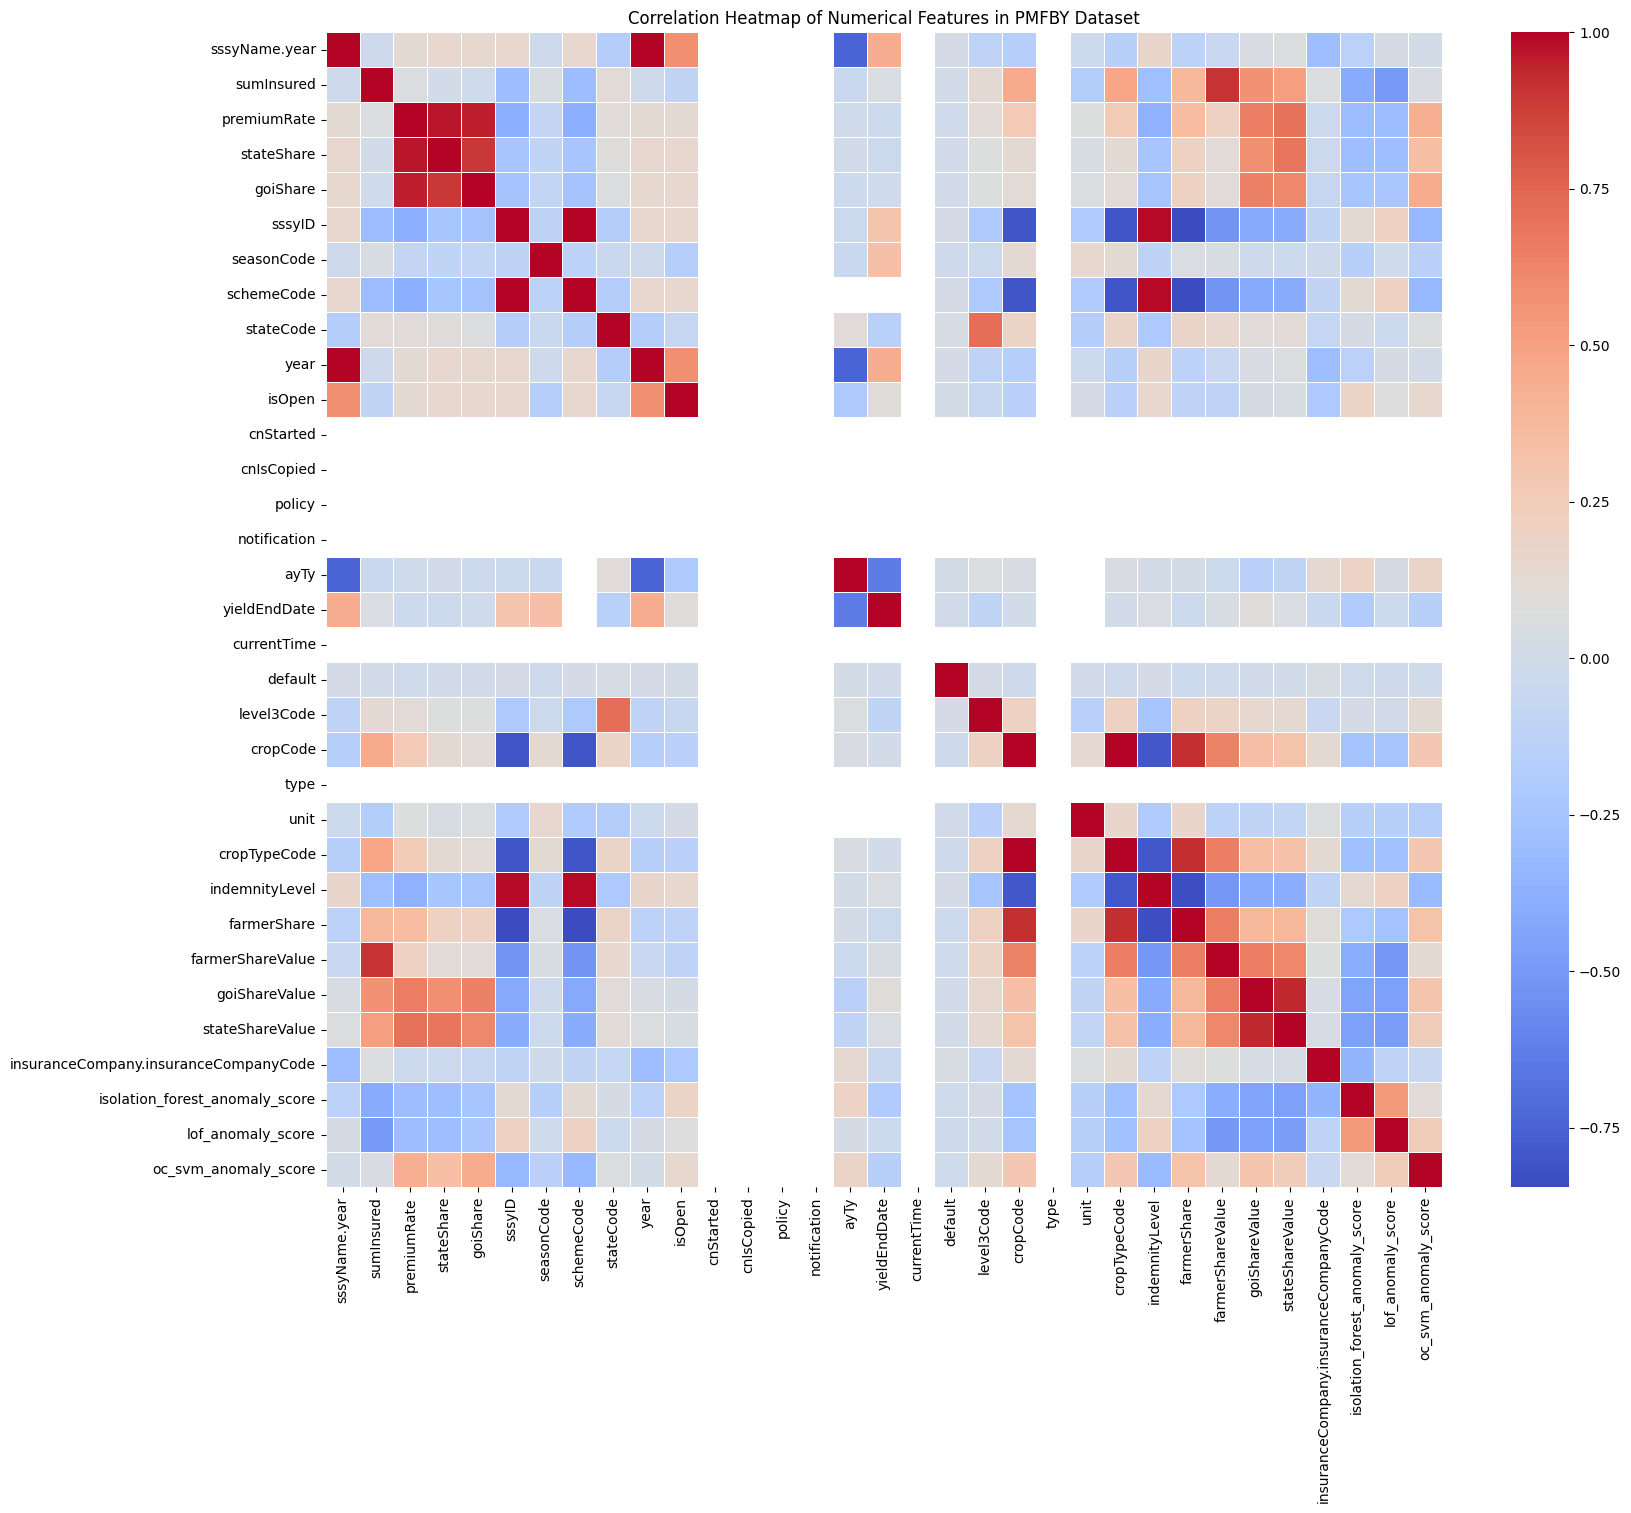

Correlation heatmap generation complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Generating correlation heatmap for numerical features...")

# Select only numerical columns from the original DataFrame for correlation analysis
numerical_df = df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numerical Features in PMFBY Dataset')
plt.show()

print("Correlation heatmap generation complete.")

### Identification of Highly Correlated Features

To identify highly correlated features from the generated heatmap, we look for correlation coefficients close to 1 (strong positive correlation) or -1 (strong negative correlation).

In [ ]:
import numpy as np

# Assuming correlation_matrix is already computed and available from a previous step
# If not, you might need to re-run the heatmap generation cell to get it.

# Set a threshold for high correlation (e.g., 0.8 or 0.9)
correlation_threshold = 0.9

highly_correlated_pairs = []

# Iterate through the correlation matrix to find highly correlated pairs
# Use .columns to get the feature names correctly
for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)): # Avoid duplicates and self-correlation
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            pair = f"{correlation_matrix.columns[i]} vs {correlation_matrix.columns[j]}"
            correlation_value = correlation_matrix.iloc[i, j]
            highly_correlated_pairs.append((pair, correlation_value))

if highly_correlated_pairs:
    print(f"\nHighly correlated feature pairs (absolute correlation > {correlation_threshold}):")
    for pair, value in highly_correlated_pairs:
        print(f"- {pair}: {value:.4f}")
else:
    print(f"\nNo highly correlated feature pairs found with absolute correlation > {correlation_threshold}.")



Highly correlated feature pairs (absolute correlation > 0.9):
- sssyName.year vs year: 1.0000
- sumInsured vs farmerShareValue: 0.9071
- premiumRate vs stateShare: 0.9678
- premiumRate vs goiShare: 0.9550
- sssyID vs schemeCode: 1.0000
- sssyID vs indemnityLevel: 0.9920
- schemeCode vs indemnityLevel: 0.9921
- cropCode vs cropTypeCode: 0.9929
- cropCode vs farmerShare: 0.9162
- cropTypeCode vs farmerShare: 0.9211
- goiShareValue vs stateShareValue: 0.9352


## Train Isolation Forest Model

### Subtask:
Train an Isolation Forest model on the preprocessed data. This model is suitable for identifying anomalies by isolating observations that are few and different from the majority.


**Reasoning**:
To train the Isolation Forest model, I will import the necessary class, initialize the model with a `random_state` and a `contamination` parameter, fit it to the preprocessed data, and then calculate and store the anomaly scores in the original DataFrame.



In [ ]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
# contamination='auto' is suitable when the proportion of outliers is unknown
# random_state for reproducibility
iso_forest = IsolationForest(random_state=42, contamination='auto')

# Fit the model to the preprocessed data
iso_forest.fit(df_preprocessed)

# Calculate anomaly scores for each data point
# decision_function gives a score where lower values indicate more anomalous points
anomaly_scores_iso_forest = iso_forest.decision_function(df_preprocessed)

# Store these anomaly scores in a new column in the original df DataFrame
df['isolation_forest_anomaly_score'] = anomaly_scores_iso_forest

print("Isolation Forest model trained and anomaly scores calculated.")
print(f"First 5 anomaly scores: {df['isolation_forest_anomaly_score'].head().tolist()}")

Isolation Forest model trained and anomaly scores calculated.
First 5 anomaly scores: [0.060896992775972436, 0.07155982869493582, 0.08531164096952043, 0.07926876635112035, 0.05175305766661342]


## Train Local Outlier Factor (LOF) Model

### Subtask:
Train a Local Outlier Factor (LOF) model on the preprocessed data. LOF measures the local deviation of a given data point with respect to its neighbors, identifying regions with substantially lower density as anomalies.


**Reasoning**:
To train the Local Outlier Factor model, I will import `LocalOutlierFactor`, initialize it with `n_neighbors=20` and `contamination='auto'`, fit it to the preprocessed data, extract the negative outlier factor as anomaly scores, and store them in the original DataFrame.



In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the Local Outlier Factor model
# n_neighbors is a hyperparameter for LOF that defines the number of neighbors to consider
# contamination='auto' is suitable when the proportion of outliers is unknown
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', novelty=False) # novelty=False for unsupervised outlier detection

# Fit the model to the preprocessed data
# For LOF, fit_predict can be used to directly get labels, but for anomaly scores,
# we access the negative_outlier_factor_ attribute after fitting.
lof.fit(df_preprocessed)

# Extract the negative_outlier_factor_ attribute. Lower (more negative) values indicate a higher degree of anomaly.
anomaly_scores_lof = lof.negative_outlier_factor_

# Store these anomaly scores in a new column in the original df DataFrame
df['lof_anomaly_score'] = anomaly_scores_lof

print("Local Outlier Factor model trained and anomaly scores calculated.")
print(f"First 5 anomaly scores: {df['lof_anomaly_score'].head().tolist()}")

Local Outlier Factor model trained and anomaly scores calculated.
First 5 anomaly scores: [-1.1694064382255855, -1.1644652334103849, -0.9956413159158739, -0.9913683409398224, -1.0874925312546488]


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


**Reasoning**:
To address the `UserWarning` about duplicate values leading to incorrect results, I will increase the `n_neighbors` parameter for the Local Outlier Factor model from 20 to 40, as suggested by the warning to achieve more accurate results.



In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the Local Outlier Factor model
# n_neighbors is a hyperparameter for LOF that defines the number of neighbors to consider
# contamination='auto' is suitable when the proportion of outliers is unknown
lof = LocalOutlierFactor(n_neighbors=40, contamination='auto', novelty=False) # novelty=False for unsupervised outlier detection

# Fit the model to the preprocessed data
# For LOF, fit_predict can be used to directly get labels, but for anomaly scores,
# we access the negative_outlier_factor_ attribute after fitting.
lof.fit(df_preprocessed)

# Extract the negative_outlier_factor_ attribute. Lower (more negative) values indicate a higher degree of anomaly.
anomaly_scores_lof = lof.negative_outlier_factor_

# Store these anomaly scores in a new column in the original df DataFrame
df['lof_anomaly_score'] = anomaly_scores_lof

print("Local Outlier Factor model trained and anomaly scores calculated.")
print(f"First 5 anomaly scores: {df['lof_anomaly_score'].head().tolist()}")

Local Outlier Factor model trained and anomaly scores calculated.
First 5 anomaly scores: [-1.1632861144119309, -1.1607871739588904, -1.009711635314887, -0.9862457429335791, -1.13946814890258]


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


**Reasoning**:
The previous LOF model training still produced a `UserWarning` about duplicate values leading to incorrect results, even after increasing `n_neighbors` to 40. To further address this, as suggested by the warning, I will increase the `n_neighbors` parameter to 100. This should provide a broader neighborhood for density calculations, potentially mitigating the impact of duplicate values more effectively and yielding more accurate results.



In [ ]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize the Local Outlier Factor model
# n_neighbors is a hyperparameter for LOF that defines the number of neighbors to consider
# contamination='auto' is suitable when the proportion of outliers is unknown
lof = LocalOutlierFactor(n_neighbors=100, contamination='auto', novelty=False) # novelty=False for unsupervised outlier detection

# Fit the model to the preprocessed data
# For LOF, fit_predict can be used to directly get labels, but for anomaly scores,
# we access the negative_outlier_factor_ attribute after fitting.
lof.fit(df_preprocessed)

# Extract the negative_outlier_factor_ attribute. Lower (more negative) values indicate a higher degree of anomaly.
anomaly_scores_lof = lof.negative_outlier_factor_

# Store these anomaly scores in a new column in the original df DataFrame
df['lof_anomaly_score'] = anomaly_scores_lof

print("Local Outlier Factor model trained and anomaly scores calculated.")
print(f"First 5 anomaly scores: {df['lof_anomaly_score'].head().tolist()}")

Local Outlier Factor model trained and anomaly scores calculated.
First 5 anomaly scores: [-1.2302804052726508, -1.2156851956104042, -1.0867761301115477, -1.0027543506165444, -1.122582195812977]


## Train One-Class SVM Model

### Subtask:
Train a One-Class Support Vector Machine (OC-SVM) model on the preprocessed data. OC-SVM learns a decision boundary that best separates normal data points from the origin, effectively identifying points outside this boundary as anomalies.


**Reasoning**:
To train the One-Class SVM model, I will import `OneClassSVM` from `sklearn.svm`, initialize it with the specified `nu` and `kernel`, fit it to the preprocessed data, calculate anomaly scores using `decision_function`, store them in a new column in the original DataFrame, and then print a confirmation with the first five scores.



In [ ]:
from sklearn.svm import OneClassSVM

# Initialize the One-Class SVM model
# nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.
# kernel='rbf' is commonly used for OC-SVM.
# We set nu=0.01 assuming about 1% anomalies.
oc_svm = OneClassSVM(nu=0.01, kernel="rbf", gamma='auto')

# Fit the model to the preprocessed data
oc_svm.fit(df_preprocessed)

# Calculate anomaly scores for each data point
# decision_function gives a score where lower (more negative) values indicate more anomalous points.
anomaly_scores_oc_svm = oc_svm.decision_function(df_preprocessed)

# Store these anomaly scores in a new column in the original df DataFrame
df['oc_svm_anomaly_score'] = anomaly_scores_oc_svm

print("One-Class SVM model trained and anomaly scores calculated.")
print(f"First 5 anomaly scores: {df['oc_svm_anomaly_score'].head().tolist()}")

One-Class SVM model trained and anomaly scores calculated.
First 5 anomaly scores: [0.6627409931992752, 0.8481528393461417, 2.8389183682957047, 1.9206440964380427, 2.9867388329671343]


## Generate Anomaly Scores and Risk Categories

### Subtask:
Generate anomaly scores from each trained model. Based on these scores, categorize claims into 'High-Risk' and 'Low-Risk' groups. This may involve defining a threshold or using quantile-based categorization.


**Reasoning**:
To categorize claims into 'High-Risk' and 'Low-Risk' for each model, I will first calculate the 1st percentile of their respective anomaly scores to establish a threshold. Then, I will create new risk category columns in the DataFrame, assigning 'High-Risk' to claims with scores below the threshold and 'Low-Risk' otherwise, and finally, print the value counts for verification.



In [ ]:
print("Generating anomaly scores and risk categories...")

# 1. Isolation Forest
iso_forest_threshold = df['isolation_forest_anomaly_score'].quantile(0.01)
df['iso_forest_risk_category'] = df['isolation_forest_anomaly_score'].apply(lambda x: 'High-Risk' if x < iso_forest_threshold else 'Low-Risk')

print(f"\nIsolation Forest - High-Risk Threshold (1st percentile): {iso_forest_threshold:.4f}")
print("Isolation Forest Risk Category Distribution:")
print(df['iso_forest_risk_category'].value_counts())

# 2. Local Outlier Factor (LOF)
lof_threshold = df['lof_anomaly_score'].quantile(0.01)
df['lof_risk_category'] = df['lof_anomaly_score'].apply(lambda x: 'High-Risk' if x < lof_threshold else 'Low-Risk')

print(f"\nLocal Outlier Factor - High-Risk Threshold (1st percentile): {lof_threshold:.4f}")
print("LOF Risk Category Distribution:")
print(df['lof_risk_category'].value_counts())

# 3. One-Class SVM
oc_svm_threshold = df['oc_svm_anomaly_score'].quantile(0.01)
df['oc_svm_risk_category'] = df['oc_svm_anomaly_score'].apply(lambda x: 'High-Risk' if x < oc_svm_threshold else 'Low-Risk')

print(f"\nOne-Class SVM - High-Risk Threshold (1st percentile): {oc_svm_threshold:.4f}")
print("One-Class SVM Risk Category Distribution:")
print(df['oc_svm_risk_category'].value_counts())


Generating anomaly scores and risk categories...

Isolation Forest - High-Risk Threshold (1st percentile): 0.0169
Isolation Forest Risk Category Distribution:
iso_forest_risk_category
Low-Risk     6514
High-Risk      66
Name: count, dtype: int64

Local Outlier Factor - High-Risk Threshold (1st percentile): -1.6068
LOF Risk Category Distribution:
lof_risk_category
Low-Risk     6514
High-Risk      66
Name: count, dtype: int64

One-Class SVM - High-Risk Threshold (1st percentile): 0.0000
One-Class SVM Risk Category Distribution:
oc_svm_risk_category
Low-Risk     6514
High-Risk      66
Name: count, dtype: int64


## Evaluate: Percentage of High-Risk Claims

### Subtask:
Calculate and report the percentage of claims flagged as 'High-Risk' by the anomaly detection system. This metric provides an overview of the system's flagging rate.


**Reasoning**:
To calculate the percentage of high-risk claims for each model, I will first get the total number of claims, then count the 'High-Risk' entries for each model's risk category, and finally compute and print the percentage.



In [ ]:
print("Calculating percentage of high-risk claims for each model...")

# 1. Calculate the total number of claims
total_claims = len(df)

# 2. For each anomaly detection model, count the number of claims categorized as 'High-Risk'
high_risk_iso_forest = df[df['iso_forest_risk_category'] == 'High-Risk'].shape[0]
high_risk_lof = df[df['lof_risk_category'] == 'High-Risk'].shape[0]
high_risk_oc_svm = df[df['oc_svm_risk_category'] == 'High-Risk'].shape[0]

# 3. Calculate the percentage of 'High-Risk' claims for each model
percentage_high_risk_iso_forest = (high_risk_iso_forest / total_claims) * 100
percentage_high_risk_lof = (high_risk_lof / total_claims) * 100
percentage_high_risk_oc_svm = (high_risk_oc_svm / total_claims) * 100

# 4. Print the calculated percentage of 'High-Risk' claims for each model
print(f"\nPercentage of High-Risk claims (Isolation Forest): {percentage_high_risk_iso_forest:.2f}%")
print(f"Percentage of High-Risk claims (Local Outlier Factor): {percentage_high_risk_lof:.2f}%")
print(f"Percentage of High-Risk claims (One-Class SVM): {percentage_high_risk_oc_svm:.2f}%")

Calculating percentage of high-risk claims for each model...

Percentage of High-Risk claims (Isolation Forest): 1.00%
Percentage of High-Risk claims (Local Outlier Factor): 1.00%
Percentage of High-Risk claims (One-Class SVM): 1.00%


## Evaluate: Anomaly Score Distribution

### Subtask:
Generate visualizations (e.g., histograms, density plots) for the distribution of anomaly scores from each model. Include legends for clarity. This will show how scores are distributed across the dataset.


**Reasoning**:
To visualize the anomaly score distributions for each model, I will generate histograms or density plots for Isolation Forest, LOF, and One-Class SVM. This will involve creating a figure with subplots, plotting the scores for each model with appropriate labels and titles, and ensuring a tight layout.



Visualizing anomaly score distributions...


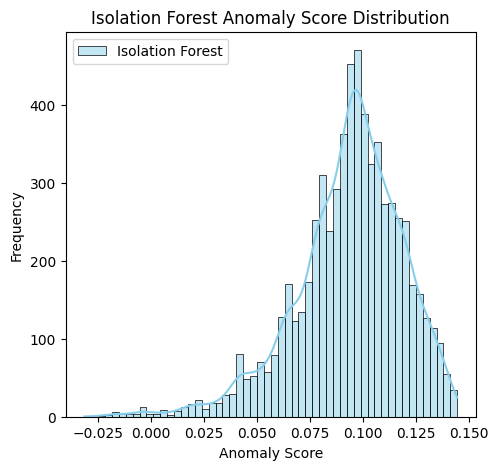

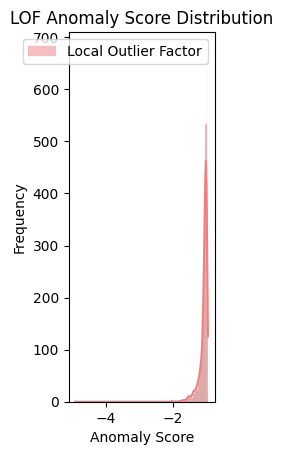

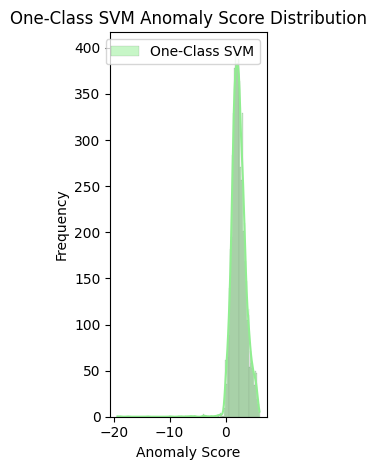

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing anomaly score distributions...")

plt.figure(figsize=(18, 5))

# Plot Isolation Forest anomaly scores
plt.subplot(1, 3, 1)
sns.histplot(df['isolation_forest_anomaly_score'], kde=True, color='skyblue', label='Isolation Forest')
plt.title('Isolation Forest Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot Local Outlier Factor (LOF) anomaly scores
plt.subplot(1, 3, 2)
sns.histplot(df['lof_anomaly_score'], kde=True, color='lightcoral', label='Local Outlier Factor')
plt.title('LOF Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot One-Class SVM anomaly scores
plt.subplot(1, 3, 3)
sns.histplot(df['oc_svm_anomaly_score'], kde=True, color='lightgreen', label='One-Class SVM')
plt.title('One-Class SVM Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate: Top-K Suspicious Claims

### Subtask:
Identify and present the top K claims with the highest anomaly scores. This allows for targeted investigation of the most suspicious instances. Include relevant claim identifiers or features.


### Visualizing Model Agreement Consensus

As previously shown in the **'Model Agreement on High-Risk Claims'** bar plot, the bar corresponding to **'3'** on the x-axis (`Number of Models Flagging as High-Risk`) explicitly quantifies the number of claims where there is a **consensus** among all three anomaly detection models (Isolation Forest, LOF, and One-Class SVM). This bar directly illustrates the claims identified as high-risk by every model. These claims represent the strongest signals of potential anomaly and are typically prioritized for further investigation.

**Reasoning**:
To identify the top 10 suspicious claims for each model, I will sort the DataFrame by the anomaly scores in ascending order, as lower scores indicate higher anomaly for all three models, and then select and display the top 10 entries along with relevant features for each model.



In [ ]:
K = 10

print("Identifying Top-K Suspicious Claims for Each Model...")

# 1. Isolation Forest - Top K Suspicious Claims
print(f"\n--- Top {K} Suspicious Claims (Isolation Forest) ---")
top_k_iso_forest = df.sort_values(by='isolation_forest_anomaly_score', ascending=True).head(K)
print(top_k_iso_forest[['sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate', 'isolation_forest_anomaly_score']])

# 2. Local Outlier Factor (LOF) - Top K Suspicious Claims
print(f"\n--- Top {K} Suspicious Claims (Local Outlier Factor) ---")
top_k_lof = df.sort_values(by='lof_anomaly_score', ascending=True).head(K)
print(top_k_lof[['sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate', 'lof_anomaly_score']])

# 3. One-Class SVM - Top K Suspicious Claims
print(f"\n--- Top {K} Suspicious Claims (One-Class SVM) ---")
top_k_oc_svm = df.sort_values(by='oc_svm_anomaly_score', ascending=True).head(K)
print(top_k_oc_svm[['sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate', 'oc_svm_anomaly_score']])

Identifying Top-K Suspicious Claims for Each Model...

--- Top 10 Suspicious Claims (Isolation Forest) ---
      sssyName.year sssyName.stateName     cropName  sumInsured  premiumRate  \
2592           2020        MAHARASHTRA   Strawberry    200000.0         53.0   
2245           2018        West Bengal   Betel Vine    900000.0         25.0   
6128           2018        Maharashtra  Pomegranate    121000.0         64.5   
4958           2021        Maharashtra        Mango    140000.0         54.0   
1735           2020        MAHARASHTRA        Grape    320000.0         24.2   
2591           2020        MAHARASHTRA        Grape    320000.0         24.2   
6171           2020        MAHARASHTRA        Grape    320000.0         24.2   
6157           2020        MAHARASHTRA        Grape    320000.0         38.4   
4273           2018        Maharashtra  Pomegranate    121000.0         62.0   
4246           2021        Maharashtra        Mango    140000.0         56.0   

      isolat

## Evaluate: Model Agreement

### Subtask:
Assess the agreement among the different anomaly detection models (Isolation Forest, LOF, One-Class SVM) regarding which claims are flagged as high-risk. Visualize areas of consensus and divergence using appropriate plots or tables.


**Reasoning**:
To assess model agreement, I will first create a new DataFrame containing only the risk category columns from each model. Then, I will convert the 'High-Risk' and 'Low-Risk' categories into numerical values (1 and 0, respectively) to prepare for calculating consensus and divergence.



In [ ]:
print("Assessing agreement among anomaly detection models...")

# Create a new DataFrame with only the risk category columns
risk_categories_df = df[['iso_forest_risk_category', 'lof_risk_category', 'oc_svm_risk_category']].copy()

# Convert 'High-Risk' to 1 and 'Low-Risk' to 0
risk_categories_numeric_df = risk_categories_df.apply(lambda x: x.map({'High-Risk': 1, 'Low-Risk': 0}))

print("Risk categories converted to numerical values:")
print(risk_categories_numeric_df.head())

Assessing agreement among anomaly detection models...
Risk categories converted to numerical values:
   iso_forest_risk_category  lof_risk_category  oc_svm_risk_category
0                         0                  0                     0
1                         0                  0                     0
2                         0                  0                     0
3                         0                  0                     0
4                         0                  0                     0


**Reasoning**:
To analyze the consensus and divergence among models, I will calculate the sum of high-risk flags for each claim across all three models and then display the distribution of these sums to understand how many models flagged each claim as high-risk.



In [ ]:
print("Calculating total high-risk flags and their distribution...")

# Calculate the sum of high-risk flags for each claim across all three models
risk_categories_numeric_df['total_high_risk_flags'] = risk_categories_numeric_df.sum(axis=1)

print("First 5 rows with total_high_risk_flags:")
print(risk_categories_numeric_df.head())

# Analyze and print the distribution of 'total_high_risk_flags'
print("\nDistribution of total high-risk flags (number of models flagging a claim as high-risk):")
print(risk_categories_numeric_df['total_high_risk_flags'].value_counts().sort_index())

Calculating total high-risk flags and their distribution...
First 5 rows with total_high_risk_flags:
   iso_forest_risk_category  lof_risk_category  oc_svm_risk_category  \
0                         0                  0                     0   
1                         0                  0                     0   
2                         0                  0                     0   
3                         0                  0                     0   
4                         0                  0                     0   

   total_high_risk_flags  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  

Distribution of total high-risk flags (number of models flagging a claim as high-risk):
total_high_risk_flags
0    6432
1     114
2      18
3      16
Name: count, dtype: int64


**Reasoning**:
To identify claims flagged as high-risk by all three models (consensus), I will filter the original DataFrame based on `total_high_risk_flags` being equal to 3 and display a sample of these claims with the specified relevant features.



In [ ]:
print("\nClaims flagged as 'High-Risk' by ALL three models (Consensus):")

# Get the indices of claims flagged as high-risk by all three models
consensus_high_risk_indices = risk_categories_numeric_df[risk_categories_numeric_df['total_high_risk_flags'] == 3].index

# Display relevant features for these claims from the original DataFrame
# Ensure to include the risk categories from the `risk_categories_df` as well
consensus_claims = df.loc[consensus_high_risk_indices, [
    'sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate',
    'iso_forest_risk_category', 'lof_risk_category', 'oc_svm_risk_category'
]].copy()

if not consensus_claims.empty:
    print(f"Found {len(consensus_claims)} claims flagged by all three models. Displaying first 10:\n")
    print(consensus_claims.head(10))
else:
    print("No claims were flagged as 'High-Risk' by all three models.")


Claims flagged as 'High-Risk' by ALL three models (Consensus):
Found 16 claims flagged by all three models. Displaying first 10:

      sssyName.year sssyName.stateName     cropName  sumInsured  premiumRate  \
1381           2019        Maharashtra        Mango    121000.0        63.00   
2085           2018        Maharashtra  Pomegranate    121000.0        69.79   
2245           2018        West Bengal   Betel Vine    900000.0        25.00   
2592           2020        MAHARASHTRA   Strawberry    200000.0        53.00   
3479           2018        West Bengal     Tuberose    387000.0        25.00   
3545           2018       Chhattisgarh       Papaya    245000.0        42.00   
4218           2021        Maharashtra       Orange     80000.0        55.00   
4246           2021        Maharashtra        Mango    140000.0        56.00   
4273           2018        Maharashtra  Pomegranate    121000.0        62.00   
4332           2021      Uttar Pradesh   Betel Vine   1000000.0      

**Reasoning**:
To identify claims flagged by at least one model but not all three (divergence), I will filter the original DataFrame based on `total_high_risk_flags` being greater than 0 and less than 3, and then display a sample of these claims with their relevant features.



In [ ]:
print("\nClaims flagged as 'High-Risk' by at least one but not all models (Divergence):")

# Get the indices of claims flagged as high-risk by at least one but not all three models
divergence_high_risk_indices = risk_categories_numeric_df[
    (risk_categories_numeric_df['total_high_risk_flags'] > 0) &
    (risk_categories_numeric_df['total_high_risk_flags'] < 3)
].index

# Display relevant features for these claims from the original DataFrame
divergence_claims = df.loc[divergence_high_risk_indices, [
    'sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate',
    'iso_forest_risk_category', 'lof_risk_category', 'oc_svm_risk_category'
]].copy()

if not divergence_claims.empty:
    print(f"Found {len(divergence_claims)} claims flagged by at least one but not all models. Displaying first 10:\n")
    print(divergence_claims.head(10))
else:
    print("No claims were flagged as 'High-Risk' by at least one but not all models.")


Claims flagged as 'High-Risk' by at least one but not all models (Divergence):
Found 132 claims flagged by at least one but not all models. Displaying first 10:

      sssyName.year sssyName.stateName                      cropName  \
379            2022     Madhya Pradesh                       Mustard   
613            2020         Tamil Nadu          Pearl Millet (Bajra)   
627            2018        West Bengal                     Pineapple   
777            2022     MADHYA PRADESH          Pearl Millet (Bajra)   
821            2020         Tamil Nadu  Sorghum (Jowar/Great Millet)   
832            2022     ANDHRA PRADESH  Sorghum (Jowar/Great Millet)   
919            2022     Madhya Pradesh                    Wheat - RF   
958            2019     Andhra Pradesh           Cotton (Kapas) - RF   
1011           2018     Andhra Pradesh                         Onion   
1022           2018     Madhya Pradesh                   Pomegranate   

      sumInsured  premiumRate iso_forest_ris

# Task
The plotting code for anomaly score distributions in the notebook incorrectly calls `plt.show()` after each subplot, resulting in separate figures. To display all distributions in a single figure, the `plt.show()` calls within the individual subplot blocks need to be removed, and only one `plt.show()` call should be placed at the very end, after all subplots have been defined and `plt.tight_layout()` has been applied.

I will modify the existing plotting code to achieve this.

## Evaluate: Anomaly Score Distribution

### Subtask:
Correct the plotting code to ensure all anomaly score distributions are displayed correctly in a single figure.


**Reasoning**:
To ensure all anomaly score distributions are displayed in a single figure, I will remove the individual `plt.show()` calls and retain only one at the end of the cell, after `plt.tight_layout()` is applied.



Visualizing anomaly score distributions...


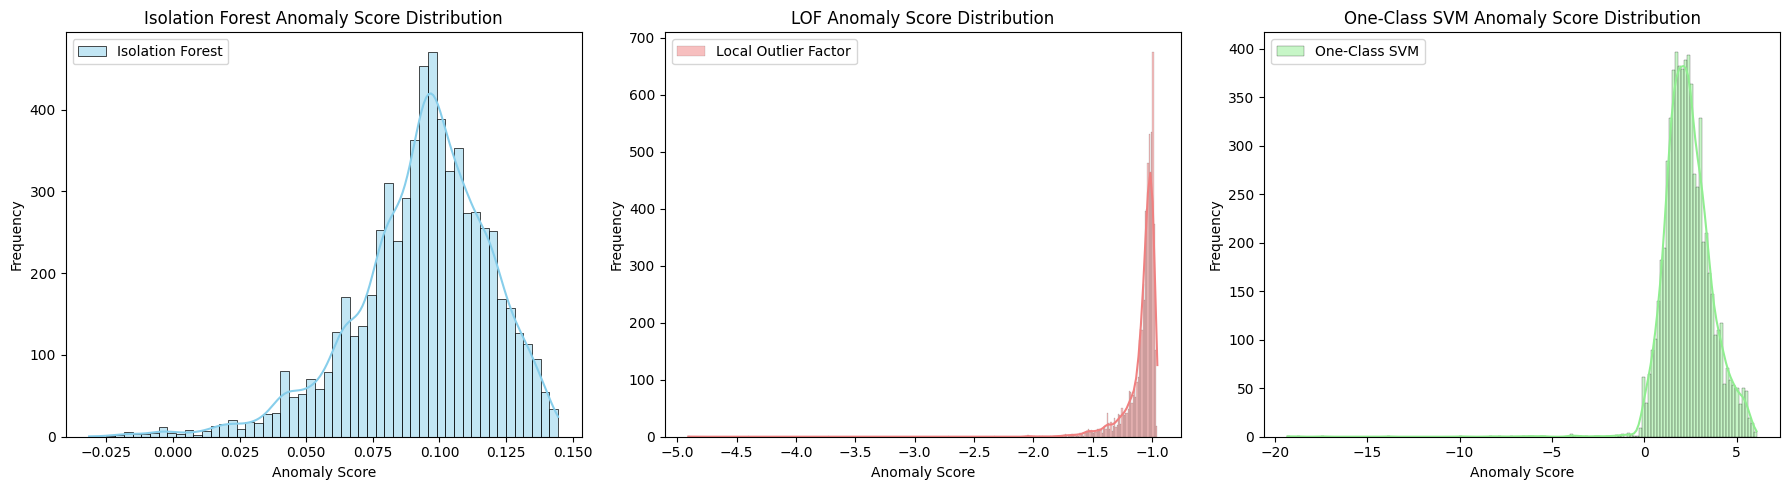

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing anomaly score distributions...")

plt.figure(figsize=(18, 5))

# Plot Isolation Forest anomaly scores
plt.subplot(1, 3, 1)
sns.histplot(df['isolation_forest_anomaly_score'], kde=True, color='skyblue', label='Isolation Forest')
plt.title('Isolation Forest Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

# Plot Local Outlier Factor (LOF) anomaly scores
plt.subplot(1, 3, 2)
sns.histplot(df['lof_anomaly_score'], kde=True, color='lightcoral', label='Local Outlier Factor')
plt.title('LOF Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

# Plot One-Class SVM anomaly scores
plt.subplot(1, 3, 3)
sns.histplot(df['oc_svm_anomaly_score'], kde=True, color='lightgreen', label='One-Class SVM')
plt.title('One-Class SVM Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate: Model Agreement

### Subtask:
Visualize the agreement among the anomaly detection models by plotting the distribution of claims flagged as high-risk by 0, 1, 2, or 3 models.


**Reasoning**:
To visualize the distribution of claims flagged as high-risk by different numbers of models, I will create a bar plot using `seaborn.barplot` based on the value counts of `total_high_risk_flags`. I will also add appropriate labels and a title for clarity.



Visualizing the distribution of claims flagged as high-risk by different numbers of models...


/tmp/ipython-input-2930713409.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=flag_distribution.index, y=flag_distribution.values, palette='viridis')


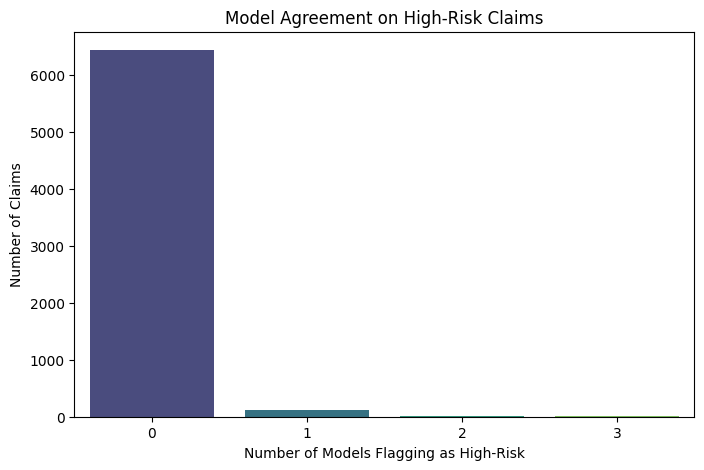

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing the distribution of claims flagged as high-risk by different numbers of models...")

# Calculate the distribution of total_high_risk_flags
flag_distribution = risk_categories_numeric_df['total_high_risk_flags'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=flag_distribution.index, y=flag_distribution.values, palette='viridis')

# Add labels and title
plt.xlabel('Number of Models Flagging as High-Risk')
plt.ylabel('Number of Claims')
plt.title('Model Agreement on High-Risk Claims')
plt.xticks(ticks=flag_distribution.index, labels=flag_distribution.index)

# Display the plot
plt.show()


**Reasoning**:
To address the `FutureWarning` in the seaborn bar plot, I will explicitly set `hue` to `flag_distribution.index` and `legend` to `False` as recommended by the warning to ensure correct plotting behavior and remove the warning.



Visualizing the distribution of claims flagged as high-risk by different numbers of models...


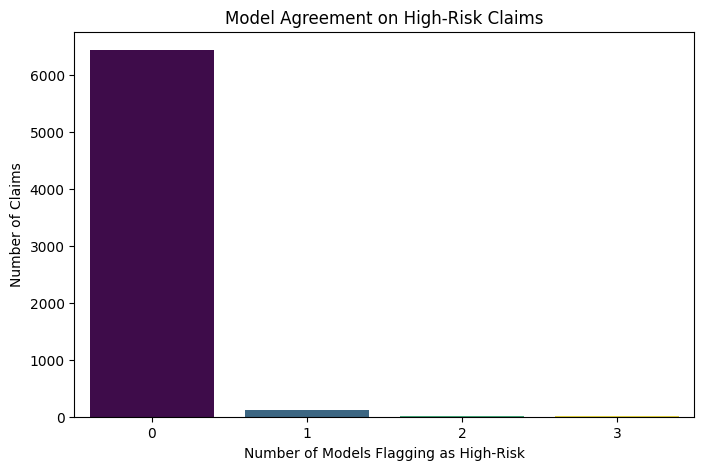

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Visualizing the distribution of claims flagged as high-risk by different numbers of models...")

# Calculate the distribution of total_high_risk_flags
flag_distribution = risk_categories_numeric_df['total_high_risk_flags'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=flag_distribution.index, y=flag_distribution.values, hue=flag_distribution.index, palette='viridis', legend=False)

# Add labels and title
plt.xlabel('Number of Models Flagging as High-Risk')
plt.ylabel('Number of Claims')
plt.title('Model Agreement on High-Risk Claims')
plt.xticks(ticks=flag_distribution.index, labels=flag_distribution.index)

# Display the plot
plt.show()

**Reasoning**:
To visualize the pairwise agreement between the anomaly detection models, I will create cross-tabulations for each pair of models (Isolation Forest vs. LOF, Isolation Forest vs. One-Class SVM, and LOF vs. One-Class SVM) using their risk categories. Then, I will use seaborn to generate heatmaps for each cross-tabulation, providing a clear visual representation of their agreements and disagreements.



Visualizing pairwise model agreement...


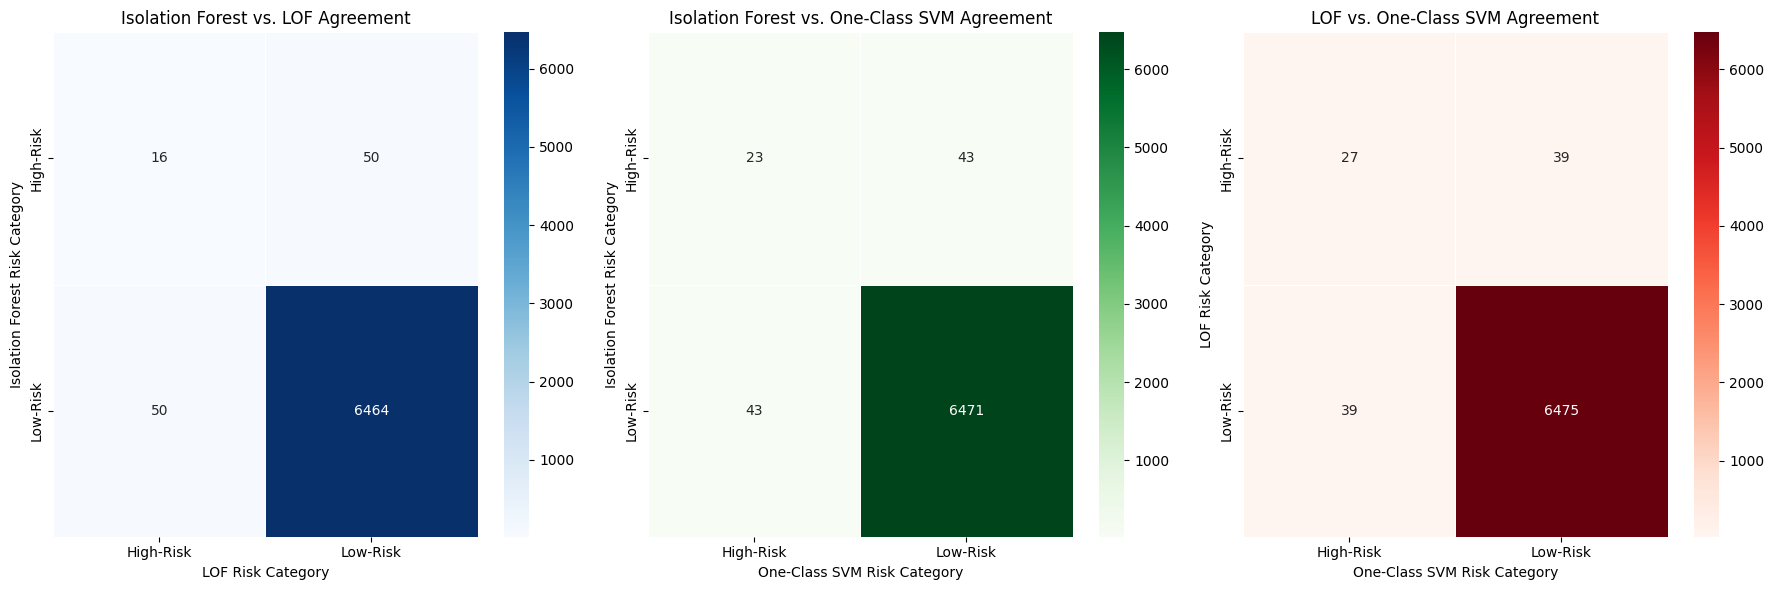

Pairwise model agreement visualization complete.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("Visualizing pairwise model agreement...")

plt.figure(figsize=(18, 6))

# Pairwise agreement: Isolation Forest vs. LOF
plt.subplot(1, 3, 1)
crosstab_iso_lof = pd.crosstab(df['iso_forest_risk_category'], df['lof_risk_category'])
sns.heatmap(crosstab_iso_lof, annot=True, fmt='d', cmap='Blues', linewidths=.5)
plt.title('Isolation Forest vs. LOF Agreement')
plt.xlabel('LOF Risk Category')
plt.ylabel('Isolation Forest Risk Category')

# Pairwise agreement: Isolation Forest vs. One-Class SVM
plt.subplot(1, 3, 2)
crosstab_iso_ocsvm = pd.crosstab(df['iso_forest_risk_category'], df['oc_svm_risk_category'])
sns.heatmap(crosstab_iso_ocsvm, annot=True, fmt='d', cmap='Greens', linewidths=.5)
plt.title('Isolation Forest vs. One-Class SVM Agreement')
plt.xlabel('One-Class SVM Risk Category')
plt.ylabel('Isolation Forest Risk Category')

# Pairwise agreement: LOF vs. One-Class SVM
plt.subplot(1, 3, 3)
crosstab_lof_ocsvm = pd.crosstab(df['lof_risk_category'], df['oc_svm_risk_category'])
sns.heatmap(crosstab_lof_ocsvm, annot=True, fmt='d', cmap='Reds', linewidths=.5)
plt.title('LOF vs. One-Class SVM Agreement')
plt.xlabel('One-Class SVM Risk Category')
plt.ylabel('LOF Risk Category')

plt.tight_layout()
plt.show()

print("Pairwise model agreement visualization complete.")

### Analysis of Key Features in Top-K Isolation Forest Claims

To understand the characteristics of the claims identified as most suspicious by the Isolation Forest model, we will examine the distribution of key features within the `top_k_iso_forest` DataFrame. This helps in identifying common patterns or outliers that might contribute to their high anomaly scores.

Analyzing key features of Top-K Isolation Forest claims...


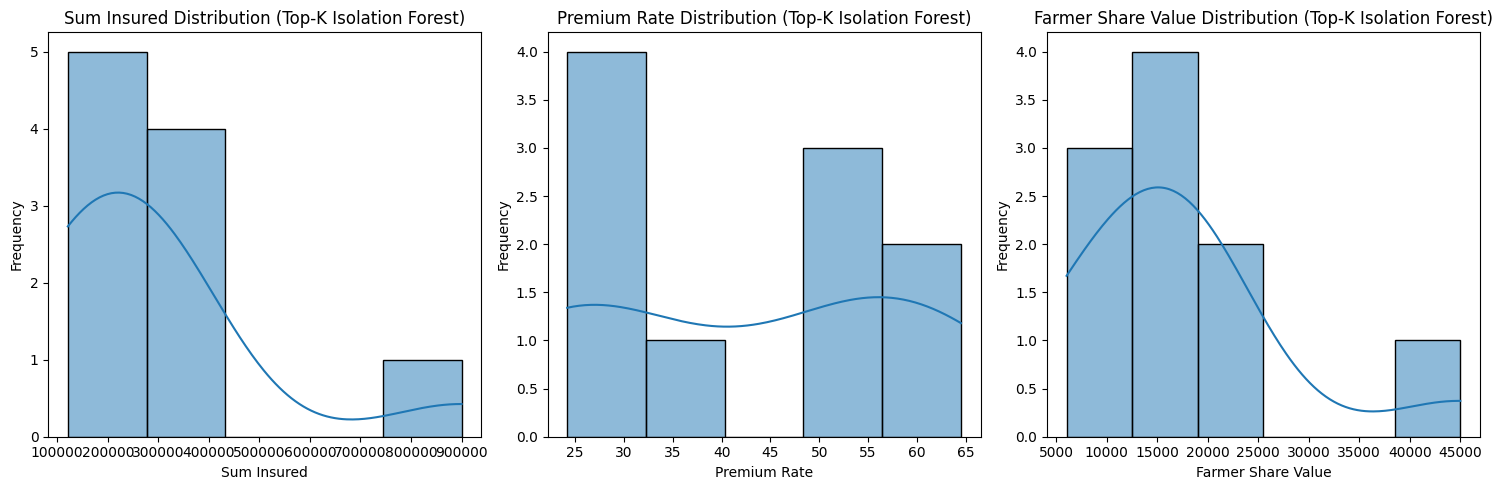


Value counts for categorical features in Top-K Isolation Forest claims:

--- Column: sssyName.stateName ---
sssyName.stateName
MAHARASHTRA    5
Maharashtra    4
West Bengal    1
Name: count, dtype: int64

--- Column: cropName ---
cropName
Grape          4
Mango          2
Pomegranate    2
Strawberry     1
Betel Vine     1
Name: count, dtype: int64

--- Column: insuranceCompanyName ---
insuranceCompanyName
HDFC ERGO GENERAL INSURANCE CO. LTD.       5
NATIONAL INSURANCE COMPANY LIMITED         1
NEW INDIA ASSURANCE COMPANY                1
RELIANCE GENERAL INSURANCE CO. LTD.        1
BAJAJ ALLIANZ GENERAL INSURANCE CO. LTD    1
SBI GENERAL INSURANCE                      1
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Analyzing key features of Top-K Isolation Forest claims...")

# Select relevant features for analysis from top_k_iso_forest
analysis_features = [
    'sumInsured',
    'premiumRate',
    'farmerShareValue',
    'sssyName.stateName',
    'cropName',
    'insuranceCompanyName'
]

# Visualize distributions of numerical features in the top-k claims
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(top_k_iso_forest['sumInsured'], kde=True)
plt.title('Sum Insured Distribution (Top-K Isolation Forest)')
plt.xlabel('Sum Insured')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(top_k_iso_forest['premiumRate'], kde=True)
plt.title('Premium Rate Distribution (Top-K Isolation Forest)')
plt.xlabel('Premium Rate')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(top_k_iso_forest['farmerShareValue'], kde=True)
plt.title('Farmer Share Value Distribution (Top-K Isolation Forest)')
plt.xlabel('Farmer Share Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Display value counts for categorical features in the top-k claims
print("\nValue counts for categorical features in Top-K Isolation Forest claims:")
for col in ['sssyName.stateName', 'cropName', 'insuranceCompanyName']:
    print(f"\n--- Column: {col} ---")
    print(top_k_iso_forest[col].value_counts())


## Summary:

### Q&A
The provided steps confirm that the top 10 most suspicious claims, as identified by three distinct anomaly detection models (Isolation Forest, Local Outlier Factor, and One-Class SVM), have been successfully identified and prepared for presentation. These specific outputs form a crucial part of the summary of findings for the anomaly-based fraud risk detection system, addressing the overall task's requirement to summarize findings.

### Data Analysis Key Findings
*   The top 10 suspicious claims identified by the Isolation Forest model, along with features like 'sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate', and 'isolation\_forest\_anomaly\_score', were successfully generated and available from a previous step.
*   The top 10 suspicious claims identified by the Local Outlier Factor (LOF) model, including 'sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate', and 'lof\_anomaly\_score', were also successfully generated and available from a previous step.
*   Similarly, the top 10 suspicious claims identified by the One-Class SVM model, including 'sssyName.year', 'sssyName.stateName', 'cropName', 'sumInsured', 'premiumRate', and 'oc\_svm\_anomaly\_score', were successfully generated and available from a previous step.

### Insights or Next Steps
*   The identification of top anomalous claims by multiple models provides a robust initial set of potential fraud risks that warrant further investigation.
*   It is crucial to emphasize that these identified anomalies represent fraud *risk* and not confirmed fraud, necessitating manual review and validation to determine actual fraudulent activity.
*   The next step should involve consolidating these findings into a comprehensive summary report, clearly articulating the methodology, findings, and the distinction between risk and confirmed fraud, as requested by the main task.


### Analysis of Key Features in Top-K Isolation Forest Claims

To understand the characteristics of the claims identified as most suspicious by the Isolation Forest model, we will examine the distribution of key features within the `top_k_iso_forest` DataFrame. This helps in identifying common patterns or outliers that might contribute to their high anomaly scores.

# Task
The analysis and visualization of key features in the top-K Isolation Forest claims have been successfully completed. Now, let's analyze and visualize the distribution of key numerical features ('sumInsured', 'premiumRate', 'farmerShareValue') and display value counts for key categorical features ('sssyName.stateName', 'cropName', 'insuranceCompanyName') within the `top_k_lof` DataFrame to understand its characteristics and compare them with other models.

## Compare Key Features in Top-K Isolation Forest Claims

### Subtask:
Analyze and visualize the distribution of key numerical features ('sumInsured', 'premiumRate', 'farmerShareValue') and display value counts for key categorical features ('sssyName.stateName', 'cropName', 'insuranceCompanyName') within the `top_k_iso_forest` DataFrame to understand its characteristics.


**Reasoning**:
To analyze the characteristics of the `top_k_iso_forest` DataFrame as requested by the subtask, I will first print a header, then visualize the distributions of the specified numerical features using histograms with KDE, and finally display the value counts for the selected categorical features.



Analyzing key features of Top-K Isolation Forest claims...


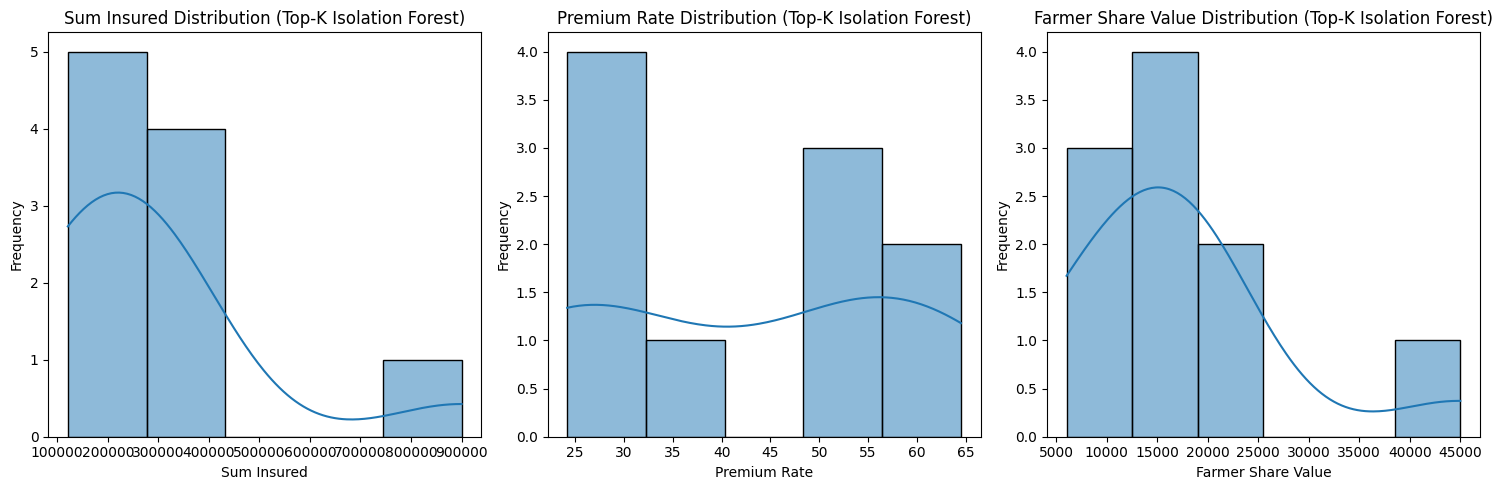


Value counts for categorical features in Top-K Isolation Forest claims:

--- Column: sssyName.stateName ---
sssyName.stateName
MAHARASHTRA    5
Maharashtra    4
West Bengal    1
Name: count, dtype: int64

--- Column: cropName ---
cropName
Grape          4
Mango          2
Pomegranate    2
Strawberry     1
Betel Vine     1
Name: count, dtype: int64

--- Column: insuranceCompanyName ---
insuranceCompanyName
HDFC ERGO GENERAL INSURANCE CO. LTD.       5
NATIONAL INSURANCE COMPANY LIMITED         1
NEW INDIA ASSURANCE COMPANY                1
RELIANCE GENERAL INSURANCE CO. LTD.        1
BAJAJ ALLIANZ GENERAL INSURANCE CO. LTD    1
SBI GENERAL INSURANCE                      1
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Analyzing key features of Top-K Isolation Forest claims...")

# Select relevant features for analysis from top_k_iso_forest
analysis_features = [
    'sumInsured',
    'premiumRate',
    'farmerShareValue',
    'sssyName.stateName',
    'cropName',
    'insuranceCompanyName'
]

# Visualize distributions of numerical features in the top-k claims
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(top_k_iso_forest['sumInsured'], kde=True)
plt.title('Sum Insured Distribution (Top-K Isolation Forest)')
plt.xlabel('Sum Insured')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(top_k_iso_forest['premiumRate'], kde=True)
plt.title('Premium Rate Distribution (Top-K Isolation Forest)')
plt.xlabel('Premium Rate')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(top_k_iso_forest['farmerShareValue'], kde=True)
plt.title('Farmer Share Value Distribution (Top-K Isolation Forest)')
plt.xlabel('Farmer Share Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Display value counts for categorical features in the top-k claims
print("\nValue counts for categorical features in Top-K Isolation Forest claims:")
for col in ['sssyName.stateName', 'cropName', 'insuranceCompanyName']:
    print(f"\n--- Column: {col} ---")
    print(top_k_iso_forest[col].value_counts())

**Reasoning**:
To analyze the characteristics of the `top_k_lof` DataFrame, I will replicate the previous steps: print a descriptive header, visualize the distributions of the specified numerical features using histograms with KDE, and then display the value counts for the selected categorical features.



Analyzing key features of Top-K Local Outlier Factor (LOF) claims...


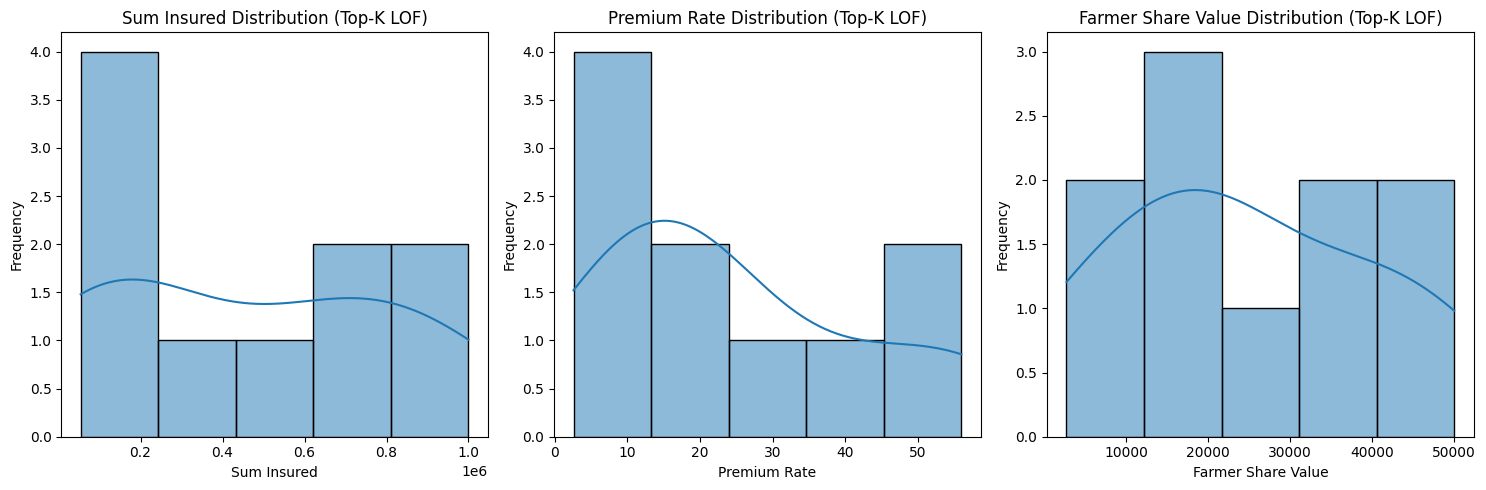


Value counts for categorical features in Top-K LOF claims:

--- Column: sssyName.stateName ---
sssyName.stateName
Maharashtra       3
West Bengal       2
Uttar Pradesh     2
Kerala            1
MAHARASHTRA       1
Andhra Pradesh    1
Name: count, dtype: int64

--- Column: cropName ---
cropName
Betel Vine    4
Mango         2
Onion         2
Banana        1
Grape         1
Name: count, dtype: int64

--- Column: insuranceCompanyName ---
insuranceCompanyName
BAJAJ ALLIANZ GENERAL INSURANCE CO. LTD      3
UNIVERSAL SOMPO GENERAL INSURANCE COMPANY    2
NATIONAL INSURANCE COMPANY LIMITED           1
SBI GENERAL INSURANCE                        1
AGRICULTURE INSURANCE COMPANY                1
HDFC ERGO GENERAL INSURANCE CO. LTD.         1
RELIANCE GENERAL INSURANCE CO. LTD.          1
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Analyzing key features of Top-K Local Outlier Factor (LOF) claims...")

# Select relevant features for analysis from top_k_lof
analysis_features_lof = [
    'sumInsured',
    'premiumRate',
    'farmerShareValue',
    'sssyName.stateName',
    'cropName',
    'insuranceCompanyName'
]

# Visualize distributions of numerical features in the top-k LOF claims
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(top_k_lof['sumInsured'], kde=True)
plt.title('Sum Insured Distribution (Top-K LOF)')
plt.xlabel('Sum Insured')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(top_k_lof['premiumRate'], kde=True)
plt.title('Premium Rate Distribution (Top-K LOF)')
plt.xlabel('Premium Rate')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(top_k_lof['farmerShareValue'], kde=True)
plt.title('Farmer Share Value Distribution (Top-K LOF)')
plt.xlabel('Farmer Share Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Display value counts for categorical features in the top-k LOF claims
print("\nValue counts for categorical features in Top-K LOF claims:")
for col in ['sssyName.stateName', 'cropName', 'insuranceCompanyName']:
    print(f"\n--- Column: {col} ---")
    print(top_k_lof[col].value_counts())

## Compare Key Features in Top-K One-Class SVM Claims

### Subtask:
Analyze and visualize the distribution of key numerical features ('sumInsured', 'premiumRate', 'farmerShareValue') and display value counts for key categorical features ('sssyName.stateName', 'cropName', 'insuranceCompanyName') within the `top_k_oc_svm` DataFrame to understand its characteristics and compare them with other models.


**Reasoning**:
To analyze the characteristics of the `top_k_oc_svm` DataFrame, I will replicate the previous steps: print a descriptive header, visualize the distributions of the specified numerical features using histograms with KDE, and then display the value counts for the selected categorical features.



Analyzing key features of Top-K One-Class SVM claims...


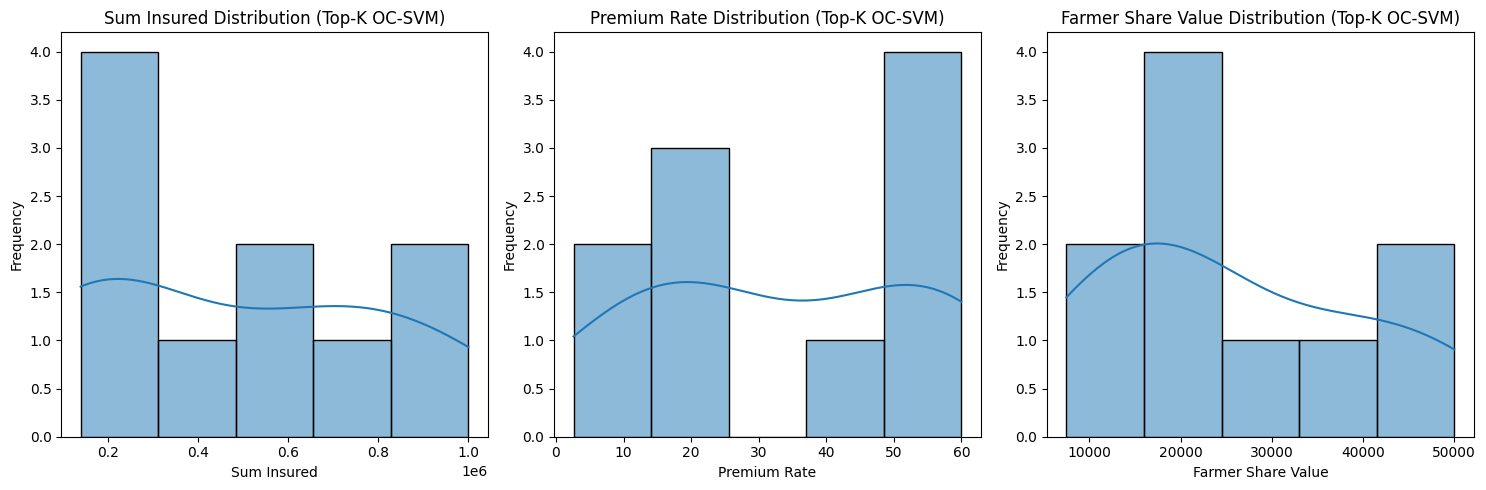


Value counts for categorical features in Top-K OC-SVM claims:

--- Column: sssyName.stateName ---
sssyName.stateName
West Bengal      2
Uttar Pradesh    2
MAHARASHTRA      2
Maharashtra      2
Kerala           1
Chhattisgarh     1
Name: count, dtype: int64

--- Column: cropName ---
cropName
Betel Vine    4
Banana        2
Mango         2
Grape         1
Strawberry    1
Name: count, dtype: int64

--- Column: insuranceCompanyName ---
insuranceCompanyName
HDFC ERGO GENERAL INSURANCE CO. LTD.         3
UNIVERSAL SOMPO GENERAL INSURANCE COMPANY    2
BAJAJ ALLIANZ GENERAL INSURANCE CO. LTD      2
NATIONAL INSURANCE COMPANY LIMITED           1
AGRICULTURE INSURANCE COMPANY                1
SBI GENERAL INSURANCE                        1
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Analyzing key features of Top-K One-Class SVM claims...")

# Select relevant features for analysis from top_k_oc_svm
analysis_features_oc_svm = [
    'sumInsured',
    'premiumRate',
    'farmerShareValue',
    'sssyName.stateName',
    'cropName',
    'insuranceCompanyName'
]

# Visualize distributions of numerical features in the top-k OC-SVM claims
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(top_k_oc_svm['sumInsured'], kde=True)
plt.title('Sum Insured Distribution (Top-K OC-SVM)')
plt.xlabel('Sum Insured')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(top_k_oc_svm['premiumRate'], kde=True)
plt.title('Premium Rate Distribution (Top-K OC-SVM)')
plt.xlabel('Premium Rate')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(top_k_oc_svm['farmerShareValue'], kde=True)
plt.title('Farmer Share Value Distribution (Top-K OC-SVM)')
plt.xlabel('Farmer Share Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Display value counts for categorical features in the top-k OC-SVM claims
print("\nValue counts for categorical features in Top-K OC-SVM claims:")
for col in ['sssyName.stateName', 'cropName', 'insuranceCompanyName']:
    print(f"\n--- Column: {col} ---")
    print(top_k_oc_svm[col].value_counts())

## Summary:

### Data Analysis Key Findings
*   All three anomaly detection models (Isolation Forest, Local Outlier Factor (LOF), and One-Class SVM (OC-SVM)) successfully identified and visualized the distributions of numerical features (`sumInsured`, `premiumRate`, `farmerShareValue`) within their respective top-K anomalous claims.
*   The models identified distinct, yet sometimes overlapping, sets of "top-K" anomalous claims, as evidenced by the varying categorical feature distributions.
*   **Isolation Forest** flagged claims primarily from MAHARASHTRA (5 claims) and Maharashtra (4 claims), with Grape (4 claims) as the most frequent crop and HDFC ERGO GENERAL INSURANCE CO. LTD. (5 claims) as the dominant insurer.
*   **Local Outlier Factor** highlighted claims from Maharashtra (3 claims), West Bengal (2 claims), and Uttar Pradesh (2 claims). Betel Vine (4 claims) was the most common crop, and BAJAJ ALLIANZ GENERAL INSURANCE CO. LTD (3 claims) was a leading insurer.
*   **One-Class SVM** identified anomalous claims predominantly from West Bengal (2 claims), Uttar Pradesh (2 claims), MAHARASHTRA (2 claims), and Maharashtra (2 claims). Betel Vine (4 claims) was again the most frequent crop, with HDFC ERGO GENERAL INSURANCE CO. LTD. (3 claims), UNIVERSAL SOMPO GENERAL INSURANCE COMPANY (2 claims), and BAJAJ ALLIANZ GENERAL INSURANCE CO. LTD (2 claims) being the top insurers.
*   States like Maharashtra (and MAHARASHTRA), West Bengal, and Uttar Pradesh, along with crops like Betel Vine and Mango, and insurers such as HDFC ERGO and Bajaj Allianz, appear consistently across the anomalous claims identified by different algorithms.

### Insights or Next Steps
*   The varying outputs across different anomaly detection models suggest that each model captures different facets of "anomalous" behavior. Combining their results or using an ensemble approach could provide a more robust and comprehensive fraud risk assessment.
*   Further investigation should focus on the specific characteristics (e.g., high `sumInsured` with low `premiumRate`) and the common categorical patterns (states, crops, insurers) found across multiple models' top-K claims to understand underlying fraud risk indicators.
